# PROJET 4 : CONSOMMATION ELECTRIQUE DE BATIMENTS (Modélisation GHG)
*Mathieu GENTHON (avril-mai 2020)*

## SOMMAIRE<a class="anchor" id="sommaire"></a>
### 1 - [Contexte du projet](#1)<a class="anchor" id="sommaire"></a>
### 2 - [Importation des librairies et chargement dataframe](#2)<a class="anchor" id="sommaire"></a>
### 3 - [kNN](#3)<a class="anchor" id="sommaire"></a>
### 4 - [Régression linéaire](#4)<a class="anchor" id="sommaire"></a>
### 5 - [Régression Ridge](#5)<a class="anchor" id="sommaire"></a>
### 6 - [Régression LASSO](#6)<a class="anchor" id="sommaire"></a>
### 7 - [Régression Elastic Net](#7)<a class="anchor" id="sommaire"></a>
### 8 - [Random Forrest](#8)<a class="anchor" id="sommaire"></a>
### 9- [(X)GBoost](#9)<a class="anchor" id="sommaire"></a>
### 10- [Comparaison des modèles](#10)<a class="anchor" id="sommaire"></a>
### 11- [Amélioration avec Energy Star Score](#11)<a class="anchor" id="sommaire"></a>
### 12- [Piste d'amélioration](#12)<a class="anchor" id="sommaire"></a>

### 1 - [Contexte du projet](#1)<a class="anchor" id="1"></a>

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

Problématique de la ville de Seattle

Des relevés minutieux ont été effectués par vos agents en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données déclaratives du permis d'exploitation commerciale (taille et usage des bâtiments, mention de travaux récents, date de construction..)

Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe.
Votre mission :
- Réaliser une courte analyse exploratoire
- Tester différents modèles de prédiction pour répondre à la problématique

Quelques pistes, et erreurs à éviter :
L'objectif est de se passer des relevés de consommation annuels (attention à la fuite de données). Déduire des variables plus simples (nature et proportions des sources d'énergies utilisées) 
Faire attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).
Mettre en place une évaluation rigoureuse des performances de la régression et optimiser les hyperparamètres et le choix d'algorithme de ML à l'aide d'une validation croisée.

### 2 - [Importation des librairies et chargement dataframe](#2)<a class="anchor" id="2"></a>

In [353]:
# On importe les librairies dont on devrait avoir besoin pour le projet.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

from sklearn import linear_model
from sklearn import model_selection
from sklearn import neighbors, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from pprint import pprint

%matplotlib inline
sns.set()
pd.set_option('display.max_columns', None) # On affiche toutes les colonnes des df
pd.options.display.max_rows = 100 # On affiche jusqu'à 100 lignes d'un df

In [354]:
# On charge les données depuis des fichiers en local et on crée des data frame pour chaque fichier.
path='C:/Users/GENTHON-M/Documents/formation/Open Classrooms/4-Consommation électrique de bâtiments/'

df_std_train = pd.read_csv(path+"df_std_train.csv")
df_std_test = pd.read_csv(path+"df_std_test.csv")

df_test2 = df_std_test.copy()
df_test2.reset_index(inplace=True)

print( df_std_train.shape,df_std_test.shape)

(2238, 65) (960, 65)


In [355]:
def Calcul_Erreur(Y_test,y_pred):
    print("MAE : {:.4f}".format( np.mean(abs(y_pred-Y_test)) ))
    print("R-squared : {:.4f}".format (r2_score(Y_test,y_pred)))
    print("MSE : {:.4f}".format( metrics.mean_squared_error(Y_test, y_pred) ))
    print("RMSE : {:.4f}".format(np.sqrt( metrics.mean_squared_error(Y_test, y_pred) )))
    
def Return_Erreur(Y_test,y_pred):
    MAE =(np.mean(abs(y_pred-Y_test)) )
   # R_squared = (r2_score(Y_test,y_pred))
    MSE = (metrics.mean_squared_error(Y_test, y_pred) )
    RMSE = (np.sqrt( metrics.mean_squared_error(Y_test, y_pred) ))
    return ( MAE, MSE, RMSE)

In [356]:
Input_Pred_To_Drop = ['SiteEnergyUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','SteamUse(kBtu)',\
             'TotalGHGEmissions','SiteEUI(kBtu/sf)','GHGEmissionsIntensity','ENERGYSTARScore',\
                      'RatioElec','RatioSteam','RatioGas']

X_train = df_std_train.drop(Input_Pred_To_Drop, axis=1)
X_test = df_std_test.drop(Input_Pred_To_Drop, axis=1)

Output = 'TotalGHGEmissions'

Y_train = df_std_train.loc[:,Output].copy()
Y_test = df_std_test.loc[:,Output].copy()

### 3 - [kNN](#3)<a class="anchor" id="3"></a>

In [358]:
from sklearn import neighbors, metrics
param_grid = {'n_neighbors':[3, 4, 5, 6, 7, 8, 9, 11, 13, 15]}

clf = model_selection.GridSearchCV(
    neighbors.KNeighborsRegressor(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring='neg_mean_absolute_error'   # score à optimiser
)

clf.fit(X_train, Y_train)

print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_params_)
print("Résultats de la validation croisée :")
for mean, params in zip(
        clf.cv_results_['mean_test_score'], # score moyen
        clf.cv_results_['params']           # valeur de l'hyperparamètre
    ):
    print("{} = {:.3f}  for {}".format('MAE',-mean, params) )

#ON prédit avec le meilleur classifieur.
y_pred = clf.predict(X_test)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 8}
Résultats de la validation croisée :
MAE = 0.271  for {'n_neighbors': 3}
MAE = 0.270  for {'n_neighbors': 4}
MAE = 0.270  for {'n_neighbors': 5}
MAE = 0.272  for {'n_neighbors': 6}
MAE = 0.269  for {'n_neighbors': 7}
MAE = 0.269  for {'n_neighbors': 8}
MAE = 0.270  for {'n_neighbors': 9}
MAE = 0.272  for {'n_neighbors': 11}
MAE = 0.274  for {'n_neighbors': 13}
MAE = 0.276  for {'n_neighbors': 15}


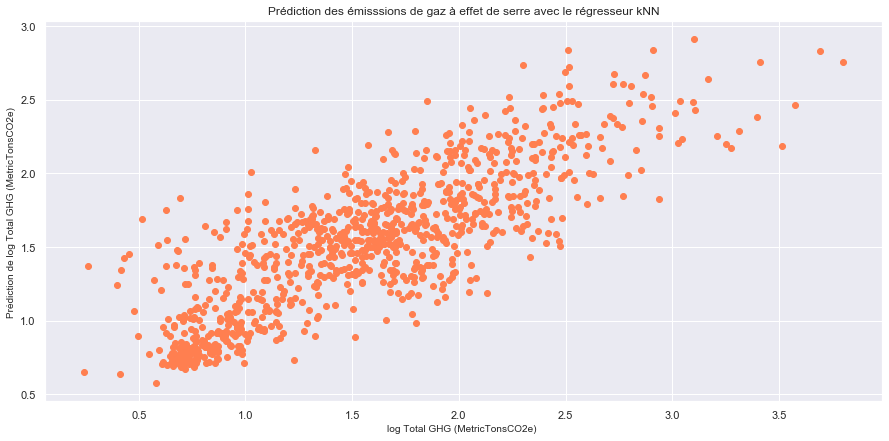

In [359]:
Abs = "log Total GHG (MetricTonsCO2e) "
Ord = "Prédiction de log Total GHG (MetricTonsCO2e) "
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel(Abs, fontsize = 10)
ax.set_ylabel(Ord, fontsize = 10)
plt.title( "Prédiction des émisssions de gaz à effet de serre avec le régresseur kNN", fontsize = 12)
plt.scatter(Y_test, y_pred, color='coral')

In [215]:
Calcul_Erreur(Y_test,y_pred)

MAE : 0.2678
R-squared : 0.6692
MSE : 0.1291
RMSE : 0.3593


### 4 - [Régression linéaire](#4)<a class="anchor" id="4"></a>

In [360]:
lr = linear_model.LinearRegression()
lr.fit(X_train, Y_train)
y_pred_rli = lr.predict(X_test)

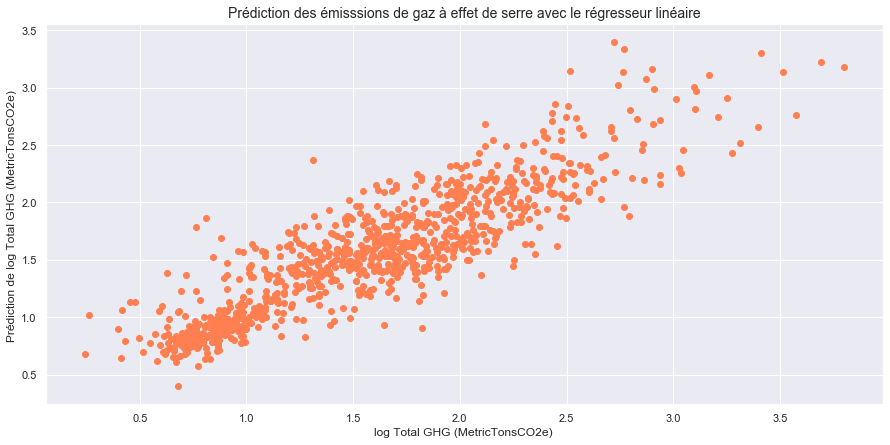

In [218]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel(Abs, fontsize = 12)
ax.set_ylabel(Ord, fontsize = 12)
plt.title("Prédiction des émisssions de gaz à effet de serre avec le régresseur linéaire", fontsize = 14)
plt.scatter(Y_test, y_pred_rli, color='coral')

In [219]:
Calcul_Erreur(Y_test,y_pred_rli)

MAE : 0.2119
R-squared : 0.7954
MSE : 0.0798
RMSE : 0.2825


### 5 - [Régression ridge](#5)<a class="anchor" id="5"></a>

In [220]:
# On récupère la MAE sur le jeu de données test comme baseline
baseline_error = np.mean(abs(y_pred_rli - Y_test))
print(baseline_error)

0.21187618245610457


In [221]:
ridge2 = linear_model.Ridge()
n_alphas = 100
alphas = np.logspace(-7, 5, n_alphas)
coefs = []
errors = []
for a in alphas:
    ridge2.set_params(alpha=a)
    ridge2.fit(X_train, Y_train)
    coefs.append(ridge2.coef_)
    errors.append([np.mean(abs(ridge2.predict(X_test) - Y_test))])

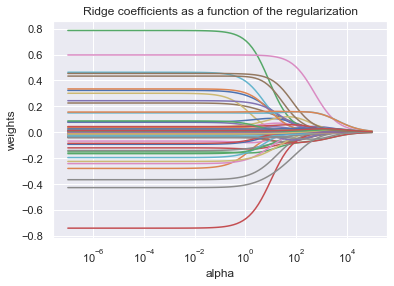

In [222]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

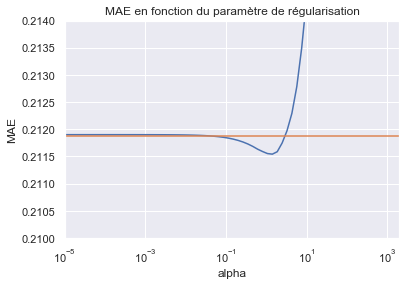

In [289]:
axes = plt.gca()
axes.plot(alphas, errors,[10**-8,10**5],[baseline_error,baseline_error])
axes.set_xscale('log')
plt.axis([0.00001,2000,0.21,0.214])
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.title('MAE en fonction du paramètre de régularisation')
plt.show()

In [227]:
min(errors)

[0.21154313380576284]

In [228]:
alphas[np.argmin(errors)]

1.4174741629268048

In [361]:
clf_rr = linear_model.RidgeCV(
    alphas=alphas,     # hyperparamètres à tester
    #cv=5,           # nombre de folds de validation croisée
    scoring='neg_mean_absolute_error',   # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf_rr.fit(X_train, Y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) et alpha sur le jeu d'entraînement:")
print(clf_rr.alpha_, clf_rr.coef_)
y_pred_rr = clf_rr.predict(X_test)

Meilleur(s) hyperparamètre(s) et alpha sur le jeu d'entraînement:
2.4770763559917137 [ 0.2535075  -0.10868208 -0.15870775 -0.12890313  0.04117291  0.18150719
 -0.07989464 -0.3091216   0.10769634  0.32224918  0.09806721 -0.00339785
  0.61636956 -0.03997615  0.02767987 -0.04751403  0.05091956 -0.11755245
  0.06826957 -0.12891626 -0.05956686  0.26462012 -0.13214476 -0.59184654
  0.21892705  0.41692347 -0.184735   -0.38728971 -0.18966073 -0.01768965
  0.01591025  0.03022564  0.00909674  0.04582724 -0.00969406 -0.00148579
 -0.00674128 -0.03783131  0.02243693 -0.02924116 -0.01636883 -0.00444473
  0.04933652 -0.04933652  0.          0.44228919  0.59465498 -0.04164181
 -0.01386337  0.14726302  0.02384128  0.15842526  0.0100446   0.01170332]


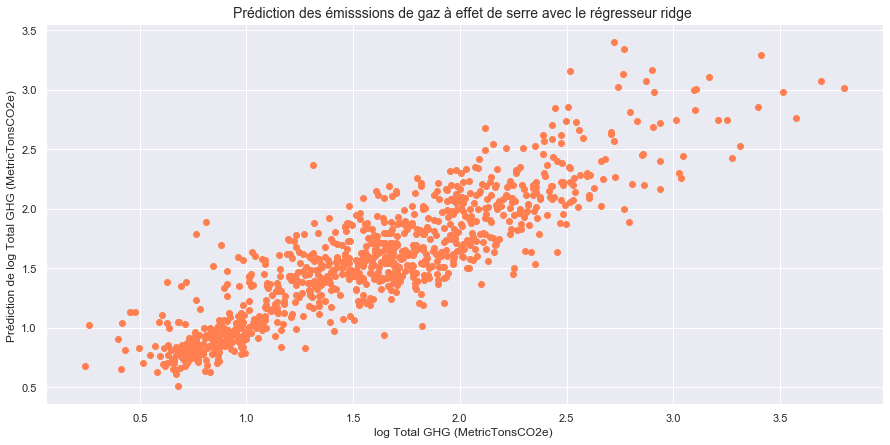

In [362]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel(Abs, fontsize = 12)
ax.set_ylabel(Ord, fontsize = 12)
plt.title("Prédiction des émisssions de gaz à effet de serre avec le régresseur ridge ", fontsize = 14)
plt.scatter(Y_test, y_pred_rr, color='coral')

In [230]:
Calcul_Erreur(Y_test,y_pred_rr)

MAE : 0.2117
R-squared : 0.7967
MSE : 0.0793
RMSE : 0.2816


### 6 - [Régression lasso](#6)<a class="anchor" id="6"></a>

In [298]:
from sklearn import model_selection
clf_lasso = linear_model.LassoCV(
    alphas=alphas,     # hyperparamètres à tester
    #cv=5,           # nombre de folds de validation croisée
    #scoring='neg_mean_absolute_error',
    #store_cv_values = True
    )

clf_lasso.fit(X_train, Y_train)

print("Meilleur(s) hyperparamètre(s) et coefficient sur le jeu d'entraînement:")
print(clf_lasso.alpha_,clf_lasso.coef_)

y_pred_lasso = clf_lasso.predict(X_test)

Meilleur(s) hyperparamètre(s) et coefficient sur le jeu d'entraînement:
0.00014174741629268049 [ 3.64812437e-01 -0.00000000e+00 -8.94481978e-02 -5.95887693e-02
  1.30820283e-01  2.74206635e-01 -0.00000000e+00 -3.07851659e-01
  1.08972848e-01  4.40587260e-01  1.15029094e-01  3.33154865e-03
  7.88384970e-01 -2.20951452e-03  3.78264148e-02 -7.99761017e-03
  6.67821385e-02 -9.90646144e-02  8.26055113e-02 -1.16232245e-01
 -2.72392615e-02  3.29610662e-01 -1.15231358e-01 -6.72262112e-01
  2.50624554e-01  4.61549470e-01 -1.77340645e-01 -3.77667991e-01
 -1.77353453e-01 -1.20368050e-02  1.84035427e-02  3.27252354e-02
  1.02308653e-02  4.78548360e-02  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -2.83457496e-02  2.58605999e-02 -2.22847037e-02
 -4.24985009e-03 -0.00000000e+00  5.63542966e-03 -3.61145222e-16
  0.00000000e+00  4.50893899e-01  5.97607433e-01 -4.18213052e-02
 -1.32541681e-02  1.48395003e-01  2.41444025e-02  1.55082794e-01
  9.36300750e-03  1.22057505e-02]


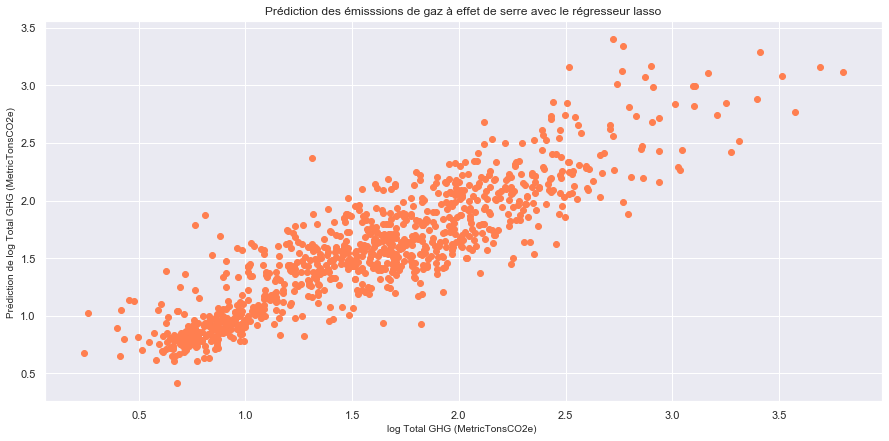

In [300]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel(Abs, fontsize = 10)
ax.set_ylabel(Ord, fontsize = 10)
plt.title("Prédiction des émisssions de gaz à effet de serre avec le régresseur lasso", fontsize = 12)
plt.scatter(Y_test, y_pred_lasso, color='coral')

In [232]:
Calcul_Erreur(Y_test,y_pred_lasso)

MAE : 0.2111
R-squared : 0.7972
MSE : 0.0791
RMSE : 0.2813


### 7 - [Régression elastic net](#7)<a class="anchor" id="7"></a>

In [364]:
clf_el_net = linear_model.ElasticNetCV(
    alphas=alphas,     # hyperparamètres à tester
    #cv=5,           # nombre de folds de validation croisée
    #store_cv_values = True
    )

clf_el_net.fit(X_train, Y_train)

print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf_el_net.alpha_)
y_pred_el_net = clf_el_net.predict(X_test)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
0.0002477076355991711


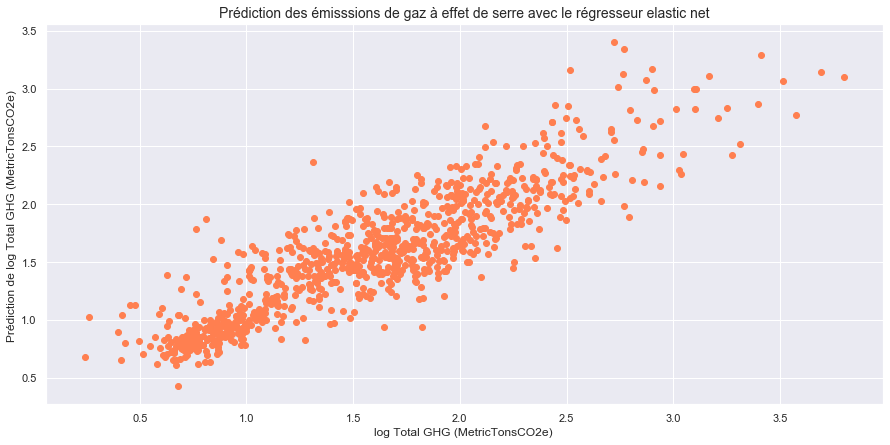

In [365]:
fig, ax = plt.subplots(figsize=(15,7))

ax.set_xlabel(Abs, fontsize = 12)
ax.set_ylabel(Ord, fontsize = 12)
plt.title("Prédiction des émisssions de gaz à effet de serre avec le régresseur elastic net", fontsize = 14)
plt.scatter(Y_test, y_pred_el_net, color='coral')

In [366]:
Calcul_Erreur(Y_test,y_pred_el_net)

MAE : 0.2112
R-squared : 0.7972
MSE : 0.0792
RMSE : 0.2813


### 8 - [Random forrest](#8)<a class="anchor" id="8"></a>

In [367]:
md = [i for i in range(4,37,3)]
mf = [j for j in range(7,37,3)]
parameters = {
    'max_depth': md,
    'max_features': mf,
             }

if __name__ == "__main__":

    clf_rfr = model_selection.GridSearchCV(RandomForestRegressor(),
                               parameters,
                               n_jobs=-1,
                               verbose=1,
                              scoring='neg_mean_absolute_error')

    print("Performing grid search...")
    print("parameters:")
    pprint(parameters)
    start_time = timeit.default_timer()
    clf_rfr.fit(X_train, Y_train)
    elapsed = timeit.default_timer() - start_time
    print("done in %0.3fs" % elapsed)
    print()

    print("Best score: %0.3f" % -clf_rfr.best_score_)
    print("Best parameters set:")
    best_parameters = clf_rfr.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
parameters:
{'max_depth': [4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34],
 'max_features': [7, 10, 13, 16, 19, 22, 25, 28, 31, 34]}
Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:  1.1min finished


done in 65.253s

Best score: 0.207
Best parameters set:
	max_depth: 31
	max_features: 19


In [368]:
start_time = timeit.default_timer()
y_pred_fa = clf_rfr.predict(X_test)
elapsed = timeit.default_timer() - start_time

MAE = np.mean(abs(y_pred_fa-Y_test))
print("MAE {:.4f} time {:.2f}s".format(MAE, elapsed))

MAE 0.2020 time 0.02s


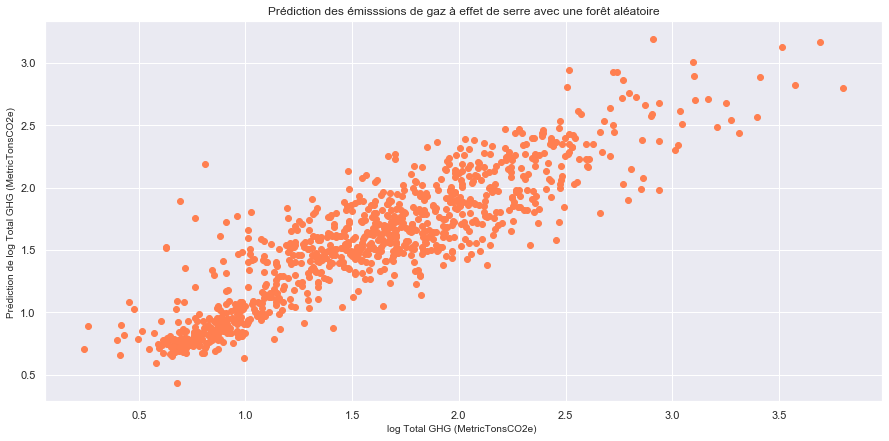

In [369]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel(Abs, fontsize = 10)
ax.set_ylabel(Ord, fontsize = 10)
plt.title("Prédiction des émisssions de gaz à effet de serre avec une forêt aléatoire", fontsize = 12)
plt.scatter(Y_test, y_pred_fa, color='coral')

In [370]:
Calcul_Erreur(Y_test,y_pred_fa)

MAE : 0.2020
R-squared : 0.7996
MSE : 0.0782
RMSE : 0.2796


In [371]:
#On sélectionne les features avec un poids supérieur au threshol de 0.003 pour améliorer le temps de calcul
rfr = RandomForestRegressor(max_depth = 22,max_features = 13)
rfr.fit(X_train, Y_train)
from sklearn.feature_selection import SelectFromModel
select = SelectFromModel(rfr, prefit=True, threshold=0.003)
X_train2 = select.transform(X_train)
X_test2 = select.transform(X_test)
print(X_train2.shape)

rfr2 = RandomForestRegressor(n_estimators=100, oob_score=True)
start_time = timeit.default_timer()
rfr2.fit(X_train2, Y_train)
pred = rfr2.predict(X_test2)
elapsed = timeit.default_timer() - start_time

MAE = np.mean(abs(pred-Y_test))
print("MAE {:.4f} time {:.2f}s".format(MAE, elapsed))

(2238, 26)
MAE 0.2074 time 1.22s


### 9 - [(X)GBoost](#9)<a class="anchor" id="9"></a>

In [240]:
md2 = [i for i in range(2,9)]
mf2 = [j for j in range(7,30,2)]
parameters = {
    'max_depth': md2,
    'max_features': mf2
             }

if __name__ == "__main__":

    clf_xgb = model_selection.GridSearchCV(GradientBoostingRegressor(),
                               parameters,
                               n_jobs=-1,
                               verbose=1,
                              scoring='neg_mean_absolute_error')

    print("Performing grid search...")
    print("parameters:")
    pprint(parameters)
    start_time = timeit.default_timer()
    clf_xgb.fit(X_train, Y_train)
    elapsed = timeit.default_timer() - start_time
    print("done in %0.3fs" % elapsed)
    print()

    print("Best score: %0.3f" % -clf_xgb.best_score_)
    print("Best parameters set:")
    best_parameters = clf_xgb.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
parameters:
{'max_depth': [2, 3, 4, 5, 6, 7, 8],
 'max_features': [7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]}
Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   18.0s finished


done in 18.282s

Best score: 0.204
Best parameters set:
	max_depth: 6
	max_features: 13


In [241]:
start_time = timeit.default_timer()
y_pred_xgb = clf_xgb.predict(X_test)
elapsed = timeit.default_timer() - start_time
MAE_XGB = np.mean(abs(y_pred_xgb-Y_test))

print("MAE {:.4f} time {:.2f}s".format(MAE_XGB, elapsed))

MAE 0.1954 time 0.00s


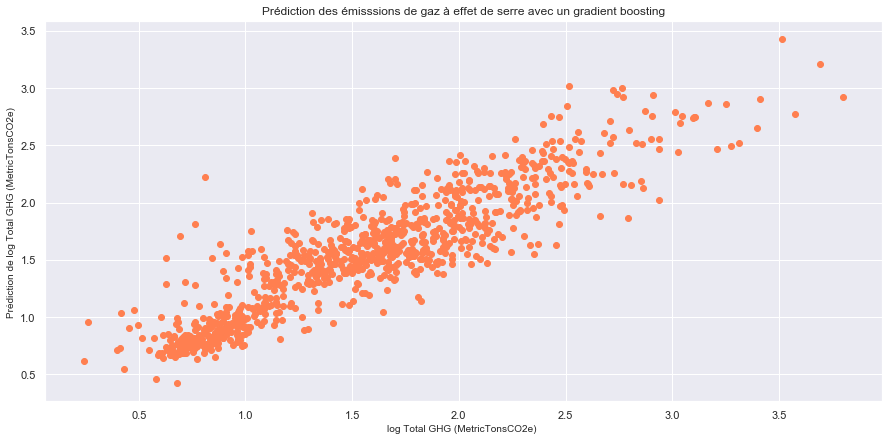

In [304]:
fig, ax = plt.subplots(figsize=(15,7))

ax.set_xlabel(Abs, fontsize = 10)
ax.set_ylabel(Ord, fontsize = 10)
plt.title("Prédiction des émisssions de gaz à effet de serre avec un gradient boosting", fontsize = 12)
plt.scatter(Y_test, y_pred_xgb, color='coral')

In [243]:
Calcul_Erreur(Y_test,y_pred_xgb)

MAE : 0.1954
R-squared : 0.8159
MSE : 0.0718
RMSE : 0.2680


In [244]:
#Feature Importance
xgb = GradientBoostingRegressor(max_depth=6,max_features=13,verbose=1)
xgb.fit(X_train, Y_train)
Val_feature_imp = xgb.feature_importances_
Feature = X_train.columns

      Iter       Train Loss   Remaining Time 
         1           0.3219            0.30s
         2           0.2810            0.29s
         3           0.2476            0.26s
         4           0.2270            0.26s
         5           0.2039            0.25s
         6           0.1813            0.25s
         7           0.1648            0.24s
         8           0.1501            0.24s
         9           0.1368            0.25s
        10           0.1254            0.27s
        20           0.0732            0.21s
        30           0.0574            0.18s
        40           0.0503            0.15s
        50           0.0460            0.12s
        60           0.0418            0.09s
        70           0.0386            0.07s
        80           0.0361            0.05s
        90           0.0336            0.02s
       100           0.0313            0.00s


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53],
 <a list of 54 Text yticklabel objects>)

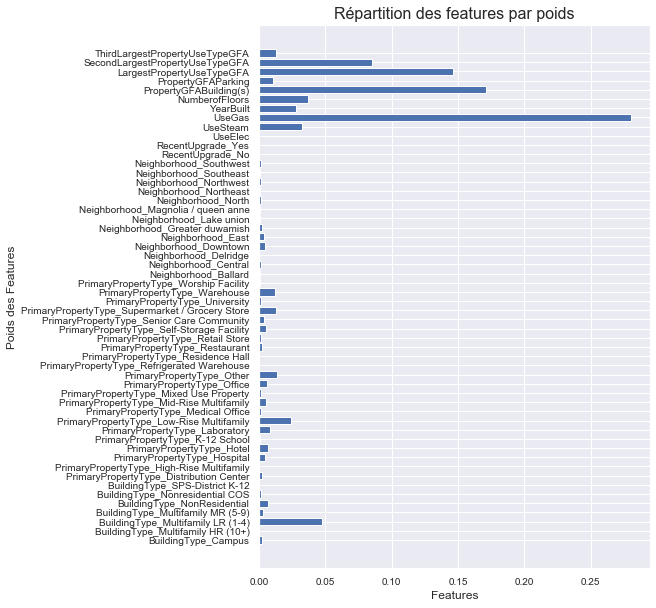

In [307]:
fig = plt.figure(figsize=(7,10))
axes = plt.axes()
axes.set_xlabel('Features', fontsize = 12)
axes.set_ylabel('Poids des Features', fontsize = 12)
#axes.set_ylim(0,1200)
plt.title('Répartition des features par poids', fontsize = 16)
plt.barh(Feature,Val_feature_imp)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [246]:
#Sauvegarde du modèle : 
import pickle
pickle.dump(xgb, open(path+'xgb_gaz.sav', 'wb'))

### 10 - [Comparaison des modèles](#10)<a class="anchor" id="10"></a>

In [255]:
kNN_result = Return_Erreur(Y_test,y_pred)
regLin_result = Return_Erreur(Y_test,y_pred_rli)
regrid_result = Return_Erreur(Y_test,y_pred_rr)
regLas_result = Return_Erreur(Y_test,y_pred_lasso)
regElNt_result = Return_Erreur(Y_test,y_pred_el_net)
RdmFo_result = Return_Erreur(Y_test,y_pred_fa)
XGbst_result = Return_Erreur(Y_test,y_pred_xgb)

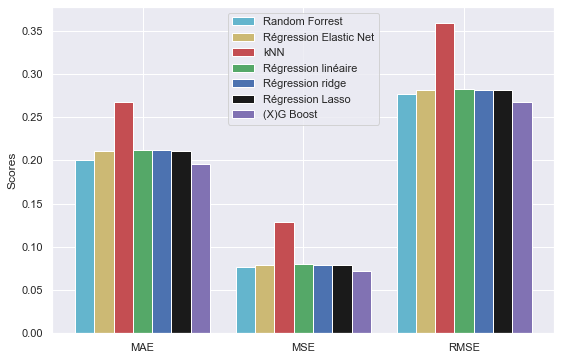

In [306]:
import numpy as np
import matplotlib.pyplot as plt

N = 3
ind = np.arange(N)  # the x locations for the groups
width = 0.12       # the width of the bars

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot()

rects1 = ax.bar(ind, kNN_result, width, color='r')
rects2 = ax.bar(ind+width, regLin_result, width, color='g')
rects3 = ax.bar(ind+width*2, regrid_result, width, color='b')
rects4 = ax.bar(ind+width*3, regLas_result, width, color='k')
rects5 = ax.bar(ind-width, regElNt_result, width, color='y')
rects6 = ax.bar(ind-width*2, RdmFo_result, width, color='c')
rects7 = ax.bar(ind+width*4, XGbst_result, width, color='m')

ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('MAE', 'MSE','RMSE') )
ax.legend( (rects6[0],rects5[0],rects1[0], rects2[0], rects3[0], rects4[0],rects7[0]), \
          ('Random Forrest','Régression Elastic Net','kNN', 'Régression linéaire', 'Régression ridge','Régression Lasso',\
           '(X)G Boost') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/6., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

plt.show()

### 11 - [Amélioration avec Energy Star Score](#11)<a class="anchor" id="11"></a>

In [258]:
print(df_std_test.shape,df_std_train.shape)

df_std_train.dropna(subset=['ENERGYSTARScore'],inplace=True)
df_std_test.dropna(subset=['ENERGYSTARScore'],inplace=True)

print(df_std_test.shape,df_std_train.shape)

(960, 65) (2238, 65)
(722, 65) (1679, 65)


In [260]:
Input_Pred_To_Drop = ['SiteEnergyUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','SteamUse(kBtu)',\
             'TotalGHGEmissions','SiteEUI(kBtu/sf)','GHGEmissionsIntensity',\
                     'RatioElec','RatioSteam','RatioGas'\
                     ]
#'SiteEnergyUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','SteamUse(kBtu)'
X_train_ES = df_std_train.drop(Input_Pred_To_Drop, axis=1)
X_test_ES = df_std_test.drop(Input_Pred_To_Drop, axis=1)

Output = 'TotalGHGEmissions'

Y_train_ES = df_std_train.loc[:,Output].copy()
Y_test_ES = df_std_test.loc[:,Output].copy()

In [261]:
md2 = [i for i in range(2,9)]
mf2 = [j for j in range(7,30,2)]
parameters = {
    'max_depth': md2,
    'max_features': mf2
             }

if __name__ == "__main__":

    clf_xgb2 = model_selection.GridSearchCV(GradientBoostingRegressor(),
                               parameters,
                               n_jobs=-1,
                               verbose=1,
                              scoring='neg_mean_absolute_error')

    print("Performing grid search...")
    print("parameters:")
    pprint(parameters)
    start_time = timeit.default_timer()
    clf_xgb2.fit(X_train_ES, Y_train_ES)
    elapsed = timeit.default_timer() - start_time
    print("done in %0.3fs" % elapsed)
    print()

    print("Best score: %0.3f" % -clf_xgb2.best_score_)
    print("Best parameters set:")
    best_parameters = clf_xgb2.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
parameters:
{'max_depth': [2, 3, 4, 5, 6, 7, 8],
 'max_features': [7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]}
Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   17.0s finished


done in 17.285s

Best score: 0.169
Best parameters set:
	max_depth: 6
	max_features: 17


In [264]:
start_time = timeit.default_timer()
y_pred_xgb_es = clf_xgb2.predict(X_test_ES)
elapsed = timeit.default_timer() - start_time

MAE_XGB_ES = np.mean(abs(y_pred_xgb_es-Y_test_ES))
print("MAE {:.4f} time {:.2f}s".format(MAE_XGB_ES, elapsed))

MAE 0.1551 time 0.00s


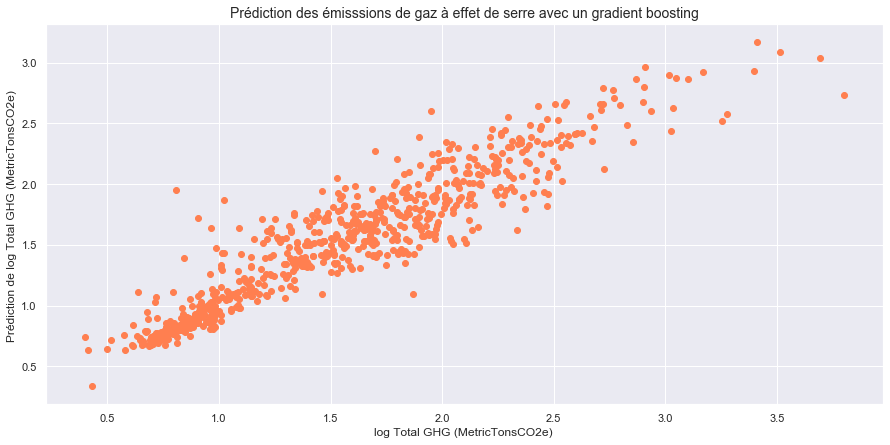

In [265]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel(Abs, fontsize = 12)
ax.set_ylabel(Ord, fontsize = 12)
plt.title("Prédiction des émisssions de gaz à effet de serre avec un gradient boosting", fontsize = 14)
plt.scatter(Y_test_ES, y_pred_xgb_es, color='coral')

In [266]:
Calcul_Erreur(Y_test_ES,y_pred_xgb_es)

MAE : 0.1551
R-squared : 0.8724
MSE : 0.0488
RMSE : 0.2209


In [345]:
# Density plot
df_plot = pd.DataFrame({'CO2_pred':y_pred_xgb_es.tolist(), 'CO2_reading':Y_test_ES.values.tolist()})

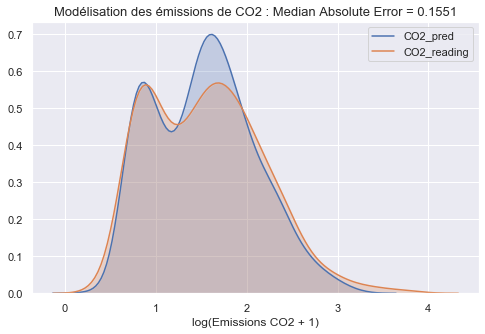

In [346]:
fig, ax = plt.subplots(figsize=(8,5))
sns.kdeplot(df_plot['CO2_pred'], shade=True, ax=ax)
sns.kdeplot(df_plot['CO2_reading'], shade=True, ax=ax)
ax.set_title('Modélisation des émissions de CO2 : Median Absolute Error = 0.1551', fontsize=13)
ax.set_xlabel('log(Emissions CO2 + 1)', fontsize=12)
plt.show()

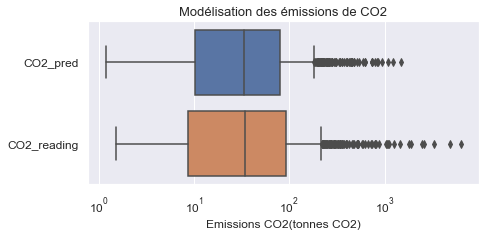

In [349]:
# Boxplot
fig, ax = plt.subplots(figsize=(7,3))
df_exp = pd.DataFrame({'CO2_pred':10**(y_pred_xgb_es)-1, 'CO2_reading':10**(Y_test_ES)-1})
Erreur = Return_Erreur(10**(y_pred_xgb_es)-1, 10**(Y_test_ES)-1)
bp = sns.boxplot(data=df_exp, orient='h')
ax.set_title('Modélisation des émissions de CO2', fontsize=13)
ax.set_xscale('log')
ax.tick_params(labelsize=12)
ax.set_xlabel('Emissions CO2(tonnes CO2)', fontsize=12)
plt.show()

In [341]:
Calcul_Erreur(10**(y_pred_xgb_es)-1, 10**(Y_test_ES)-1)

MAE : 56.5164
R-squared : -3.5105
MSE : 90132.8212
RMSE : 300.2213


In [372]:
from scipy import stats
print(np.mean(10**(Y_test_ES)-1))

117.38300554016617


### 12 - [Pistes d'amélioration](#12)<a class="anchor" id="12"></a>

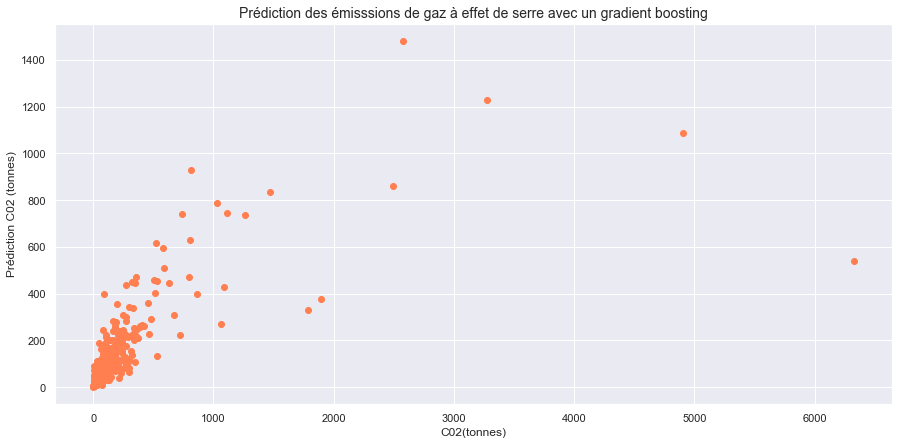

In [352]:
fig, ax = plt.subplots(figsize=(15,7))
ax.set_xlabel('C02(tonnes)', fontsize = 12)
ax.set_ylabel('Prédiction C02 (tonnes)', fontsize = 12)
plt.title("Prédiction des émisssions de gaz à effet de serre avec un gradient boosting", fontsize = 14)
plt.scatter(10**Y_test_ES-1, 10**y_pred_xgb_es-1, color='coral')

On voit que notre modèle n'est pas bon pour les valeur supérieure à 1000. ON pourrait sans doute l'améliorer en supprimant ces valeurs.